In [5]:
from collections import OrderedDict
from functools import reduce

import matplotlib.pyplot as plt
import torch
import typer
from joblib import Parallel, delayed
from repsim.geometry.hypersphere import HyperSphere
from repsim.kernels import Linear
from repsim.metrics import AngularCKA, EuclideanShapeMetric
from repsim.stats import ManifoldPCA, SphericalMDS
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import MLP, ExponentialKoopmanAutencoder
from koopmann.models.utils import get_device, parse_safetensors_metadata

%load_ext autoreload
%autoreload 2


def get_dataloader(model_file_path: str, batch_size: int = 5_000):
    """Prepare dataloader."""
    # Dataset config
    metadata = parse_safetensors_metadata(file_path=model_file_path)
    dataset_config = DatasetConfig(
        dataset_name=metadata["dataset"],
        num_samples=batch_size,
        split="test",
        seed=21,
    )
    DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
    train_dataset = DatasetClass(config=dataset_config)

    # Reduce to certain class
    # idx = torch.where(train_dataset.labels == target_class)[0]
    # subset = Subset(train_dataset, idx)
    # loader = torch.utils.data.DataLoader(train_dataset, batch_size=10_000, shuffle=True)

    dataloader = create_data_loader(train_dataset, batch_size=batch_size)
    return dataloader


def get_activations(model, autoencoder, batch, k_steps, device):
    ################## FORWARD ###############
    input, _ = batch
    with torch.no_grad():
        _ = model(input.to(device))
    act_dict = model.get_fwd_activations()

    ################## STATE SPACE PREDICTIONS ###############
    new_keys = list(range(0, k_steps + 1))
    with torch.no_grad():
        decoded_act = autoencoder(x=act_dict[0], k=k_steps).predictions.cpu()
    # ref_decoded = fit_pca(decoded_act[0])
    # decoded_act = [process_pca_and_align(decoded, ref_decoded) for decoded in decoded_act]
    decoded_act_dict = OrderedDict(zip(new_keys, decoded_act))

    # ################## OBSERVABLE SPACE PREDICTIONS ###############
    embedded_act = [autoencoder._encode(act_dict[0])] * (k_steps + 1)
    with torch.no_grad():
        embedded_act = [
            act if i == 0 else reduce(lambda x, _: autoencoder.koopman_matrix(x), range(i), act)
            for i, act in enumerate(embedded_act)
        ]
    # ref_embedded = fit_pca(embedded_act[0].cpu().detach())
    # embedded_act = [
    #     process_pca_and_align(embedded.cpu().detach().numpy(), ref_embedded)
    #     for embedded in embedded_act
    # ]
    embedded_act_dict = OrderedDict(zip(new_keys, embedded_act))

    return decoded_act_dict, embedded_act_dict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
################## FILENAME ###############
scale_idx = 1
k1 = 250
k2 = 250

dim1 = 128
dim2 = 128
model_name = "mnist_model"

model_file_path = f"/home/nsa325/work/koopmann/model_saves/{model_name}.safetensors"
ae1_file_path = f"/home/nsa325/work/koopmann/model_saves/scaling/k_{k1}_dim_{dim1}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"
ae2_file_path = f"/home/nsa325/work/koopmann/model_saves/scaling/k_{k2}_dim_{dim2}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"

# ae1_file_path = f"/scratch/nsa325/koopmann/k_{k1}_dim_{dim}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"
# ae2_file_path = f"/scratch/nsa325/koopmann/k_{k2}_dim_{dim}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"


In [7]:
device = get_device()
print(f"Using device {device}")

#################### DATA #################
batch_size = 1_00
dataloader = get_dataloader(model_file_path, batch_size)
batch = next(iter(dataloader))
input, labels = batch

################### MODELS ################
model, model_metadata = MLP.load_model(model_file_path)
model.to(device).eval().hook_model()
# autoencoder, ae_metadata = Autoencoder.load_model(ae_file_path)

autoencoder1, ae_metadata = ExponentialKoopmanAutencoder.load_model(ae1_file_path)
autoencoder1.to(device).eval()
k1_steps = int(ae_metadata["num_scaled"])

autoencoder2, ae_metadata = ExponentialKoopmanAutencoder.load_model(ae2_file_path)
autoencoder2.to(device).eval()
k2_steps = int(ae_metadata["num_scaled"])


Using device cpu


In [8]:
################# ACTIVATIONS ##############
decoded_act_dict1, embedded_act_dict1 = get_activations(
    model, autoencoder1, batch, k1_steps, device
)

decoded_act_dict2, embedded_act_dict2 = get_activations(
    model, autoencoder2, batch, k2_steps, device
)


In [9]:
# NOTE: fix naming of dict
with torch.no_grad():
    _ = model(input.to(device))
decoded_act_dict3 = model.get_fwd_activations()

# Merge both activations
merged_dict = {
    i: value
    for i, value in enumerate(
        list(decoded_act_dict1.values())
        + list(decoded_act_dict2.values())
        + list(decoded_act_dict3.values())
    )
}

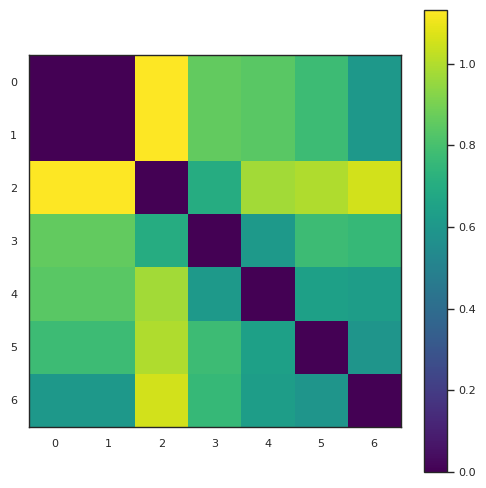

<Figure size 600x600 with 0 Axes>

In [10]:
########### DIST MATRIX VISUAL ##############
metric = AngularCKA(m=batch_size, kernel=Linear())
# metric = EuclideanShapeMetric(m=batch_size)


# Define a helper function for the computation
def compute_distances(i, act_dict, metric):
    layer_dists = torch.empty(len(act_dict))
    for j in act_dict.keys():
        if i <= j:
            dist = metric.length(
                metric.neural_data_to_point(act_dict[i]),
                metric.neural_data_to_point(act_dict[j]),
            )
            layer_dists[j] = dist
        else:
            layer_dists[j] = 0  # Placeholder, will be mirrored later
    return i, layer_dists


# Main parallel computation
with torch.no_grad():
    num_layers = len(merged_dict)
    s_pair_dists = torch.empty((num_layers, num_layers))

    results = Parallel(n_jobs=-1)(
        delayed(compute_distances)(i, merged_dict, metric) for i in merged_dict.keys()
    )

    for i, layer_dists in results:
        for j in range(len(layer_dists)):
            if i <= j:
                s_pair_dists[i][j] = layer_dists[j]
                s_pair_dists[j][i] = layer_dists[j]  # Mirror the value
            else:
                s_pair_dists[i][j] = s_pair_dists[j][i]  # Fill mirrored values

# Create the figure and axis
plt.imshow(s_pair_dists, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.show()
plt.clf()

/home/nsa325/work/koopmann/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


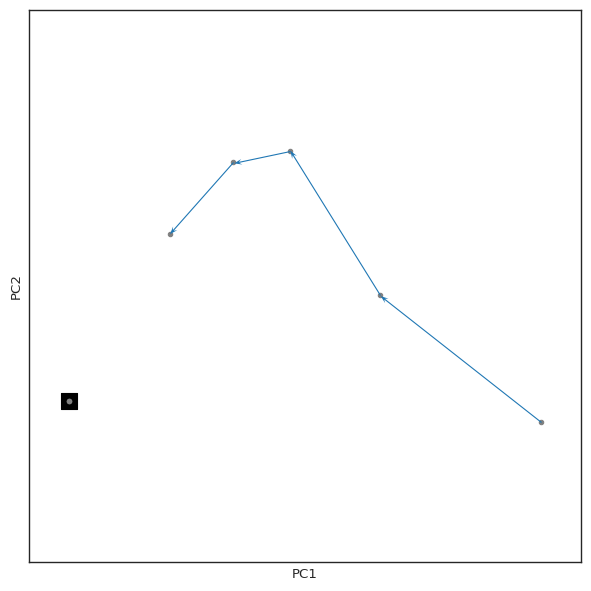

In [11]:
########### TRAJECTORY #################3
manifold_dim = 20
num_pc = 3

# sphere_mds = SphericalMDS(dim=manifold_dim, dissimilarity="precomputed").fit(s_pair_dists)
# sphere = HyperSphere(dim=manifold_dim)
# pca = ManifoldPCA(space=sphere, n_components=num_pc)
# coordinates = pca.fit_transform(sphere_mds.embedding_).float()

mds = MDS(manifold_dim, dissimilarity="precomputed").fit(s_pair_dists)
pca = PCA(n_components=num_pc)
coordinates = pca.fit_transform(mds.embedding_)

x, y = coordinates[:, 0].tolist(), coordinates[:, 1].tolist()

plt.scatter(x[0], y[0], color="black", s=120, marker="s", label="Start Point")
plt.scatter(x, y, color="grey", s=10, label="Points")

# Add arrows for trajectory
chunk_indices = [
    len(decoded_act_dict1),
    len(decoded_act_dict2),
    len(decoded_act_dict3),
]
for i in range(1, len(chunk_indices)):
    chunk_indices[i] = chunk_indices[i - 1] + chunk_indices[i]

for start, end in zip([0] + chunk_indices[:-1], chunk_indices):
    # Get the chunk of x and y
    x_chunk = x[start:end]
    y_chunk = y[start:end]

    for i in range(len(x_chunk) - 1):
        plt.quiver(
            x_chunk[i],
            y_chunk[i],  # Starting point of the arrow
            x_chunk[i + 1] - x_chunk[i],
            y_chunk[i + 1] - y_chunk[i],  # Direction of the arrow
            angles="xy",
            scale_units="xy",
            scale=1,
            color="#1f77b4",  # Nice blue color
            width=0.002,
            headwidth=5,
            headlength=7,
        )
# plt.title("2D Trajectory with Direction")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")
plt.xlim(min(x) - 0.1, max(x) + 0.1)
plt.ylim(min(y) - 0.1, max(y) + 0.1)
# plt.legend()
plt.tick_params(
    axis="both",  # Apply changes to both x-axis and y-axis
    which="both",  # Affect both major and minor ticks
    bottom=False,  # Turn off ticks along the bottom edge
    top=False,  # Turn off ticks along the top edge
    left=False,  # Turn off ticks along the left edge (y-axis)
    right=False,  # Turn off ticks along the right edge (y-axis)
    labelbottom=False,  # Turn off labels on the bottom edge (x-axis)
    labelleft=False,  # Turn off labels on the left edge (y-axis)
)
plt.tight_layout()
plt.show()
